## Report about Kvasir Dataset for Classification and Segmentation

### 1. Load dataset

First of all, we will download Kvasir dataset through kaggle.

In [1]:
import opendatasets as od

dataset_path = 'https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation'
od.download(dataset_path)

Skipping, found downloaded files in ".\kvasir-dataset-for-classification-and-segmentation" (use force=True to force download)


Then, we read image and mask paths from dataset,

In [2]:
import os

image_paths = []
mask_paths = []

dir_image = './kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images'
dir_mask = './kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks'

for image, mask in zip(os.listdir(dir_image), os.listdir(dir_mask)):
    image_paths.append(os.path.join(dir_image, image))
    mask_paths.append(os.path.join(dir_mask, mask))

and convert images and masks to their true channel.

Check the number of channels and the shape of images and masks after converting.

In [11]:
from PIL import Image 
import numpy as np

print("Image's bands: ", Image.open(image_paths[0]).convert('RGB').getbands())
print("Image's shape: ", np.array(Image.open(image_paths[0]).convert('RGB')).shape)
print(end='\n')
print("Mask's bands: ", Image.open(mask_paths[0]).convert('L').getbands())
print("Mask's shape: ", np.array(Image.open(mask_paths[0]).convert('L')).shape)

Image's bands:  ('R', 'G', 'B')
Image's shape:  (529, 622, 3)

Mask's bands:  ('L',)
Mask's shape:  (529, 622)


Beside, we also virtualize some images and masks.

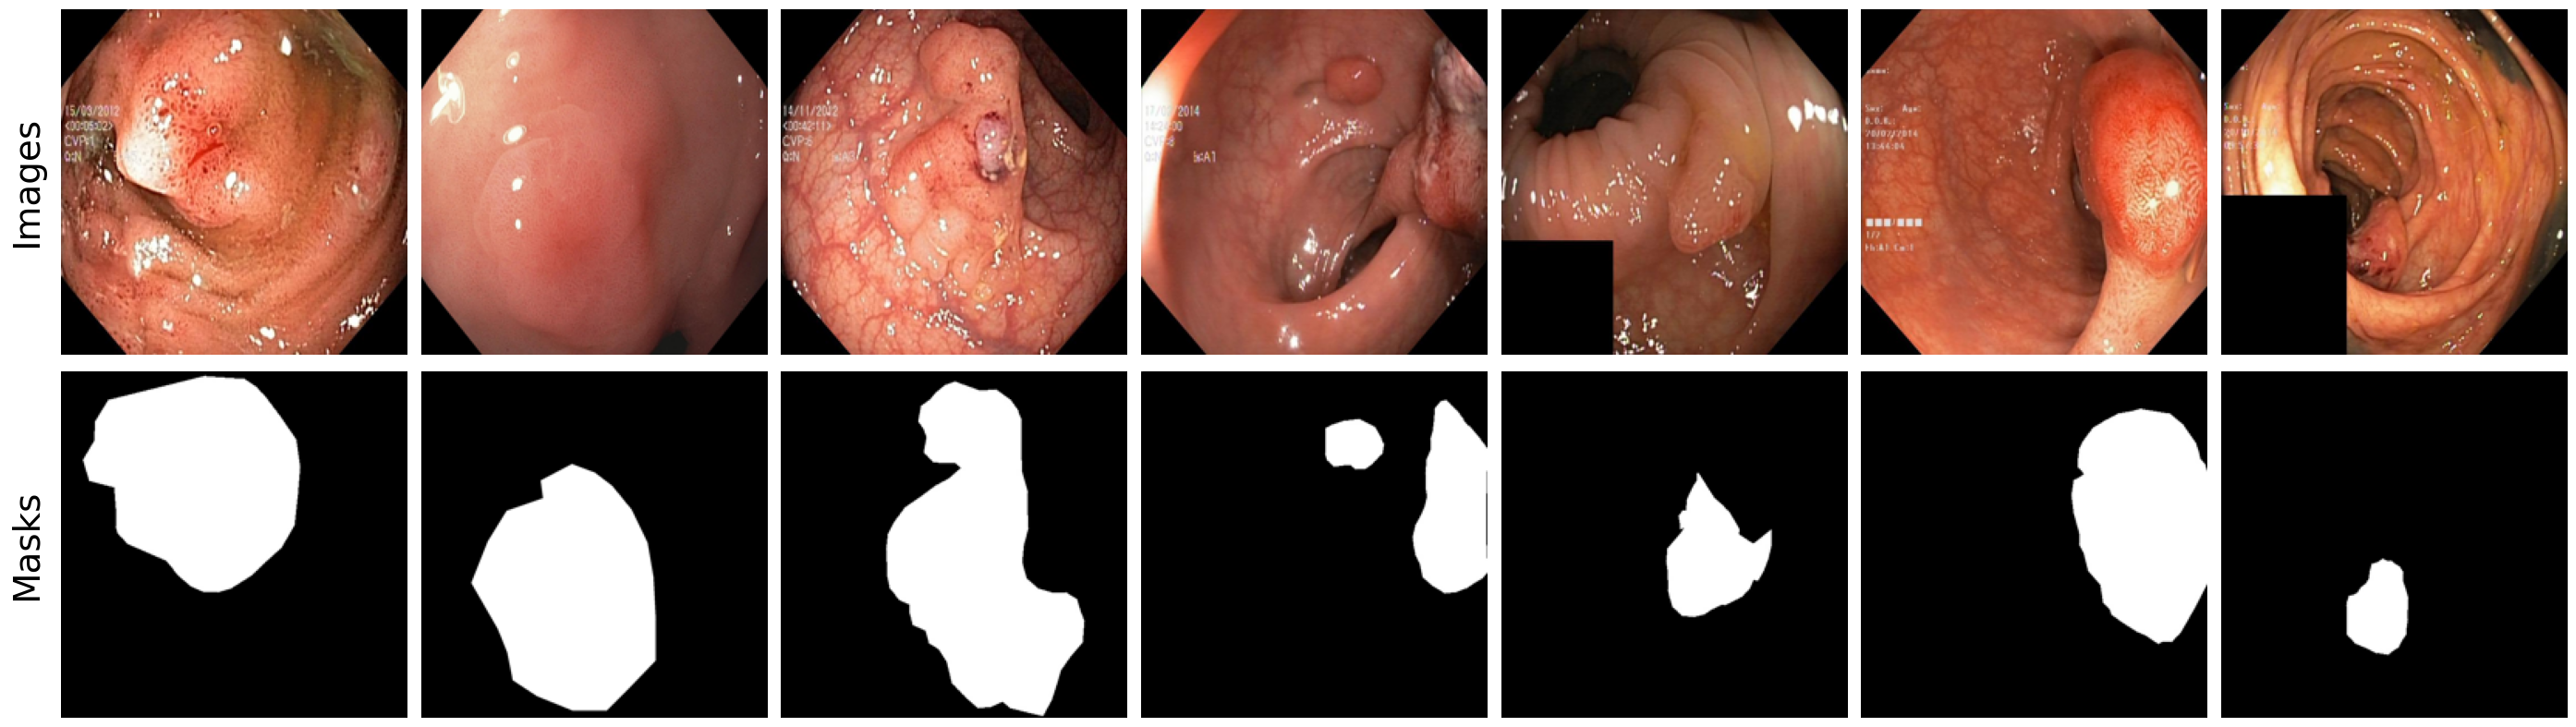

In [13]:
import matplotlib.pyplot as plt

n = 7

fig, axs = plt.subplots(2, n, figsize=(n * 5, 10))

for i in range(n):
    image = Image.open(image_paths[i]).convert('RGB')
    image = image.resize((224, 224))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

    mask = Image.open(mask_paths[i]).convert('L')
    mask = mask.resize((224, 224))
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')

plt.text(-0.15, 0.5, 'Images', va='center', rotation='vertical',
         transform=axs[0, 0].transAxes, fontsize=28)
plt.text(-0.15, 0.5, 'Masks', va='center', rotation='vertical',
         transform=axs[1, 0].transAxes, fontsize=28)

plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.show()

Split dataset into three sets: train, valid, and test. 

In [14]:
from sklearn.model_selection import train_test_split

val_size = 0.2
test_size = 0.25

# Split into train and valid
X_train, X_val, y_train, y_val = train_test_split(
    image_paths,
    mask_paths,
    test_size=val_size,
    random_state=42,
    shuffle=True
)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=42,
    shuffle=True
)

print("Train' size: ", len(X_train))
print("Val's size: ", len(X_val))
print("Test's size: ", len(X_test))

Train' size:  600
Val's size:  200
Test's size:  200


Lastly, we will define the Kvasir Dataset.

In [15]:
from torch.utils.data import Dataset

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(image_paths[idx]).convert('RGB')
        mask = Image.open(mask_paths[idx]).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

#### 2. Data augmentation and transformation

Calculate the mean and std.

In [16]:
full_data = KvasirDataset(image_paths, mask_paths)

img_data = []
for img, _ in full_data:
    img_array = np.array(img.resize((224, 224))) / 255.0
    img_data.append(img_array)

img_data = np.array(img_data)

mean = np.mean(img_data, axis=(0, 1, 2))
std = np.std(img_data, axis=(0, 1, 2))

print('Mean: ', mean)
print('Std: ', std)

Mean:  [0.55714883 0.32170294 0.23581956]
Std:  [0.31774015 0.22082197 0.18651856]


In [17]:
import torchvision.transforms as transforms
import torch

class TransForm:
    def __init__(self, image_transform, mask_transform):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        seed = torch.random.initial_seed()
        torch.manual_seed(seed)
        image = self.image_transform(image)

        torch.manual_seed(seed)
        mask = self.mask_transform(mask)

        return image, mask

train_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_mask_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

val_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_mask_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

data_transforms = {
    'train': TransForm(train_image_transforms, train_mask_transforms),
    'val': TransForm(val_image_transforms, val_mask_transforms),
}

Contruct datasets after splitting.

In [18]:
train_dataset = KvasirDataset(
    X_train,
    y_train,
    transform=data_transforms['train']
)

val_dataset = KvasirDataset(
    X_val,
    y_val,
    transform=data_transforms['val']
)

test_dataset = KvasirDataset(
    X_test,
    y_test,
    transform=data_transforms['val']
)

Contruct DataLoader.

In [19]:
from torch.utils.data import DataLoader

train_batch_size = 8
test_batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Show the batch.

In [23]:
import torchvision
train_features, train_labels = next(iter(train_loader))

def show_batch(images, masks):
    grid_images = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    grid_masks = torchvision.utils.make_grid(masks, nrow=4, normalize=True)

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_images, (1, 2, 0)), )
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_masks, (1, 2, 0)), )
    plt.show()

In [24]:
print(train_features[0].shape)

torch.Size([3, 224, 224])


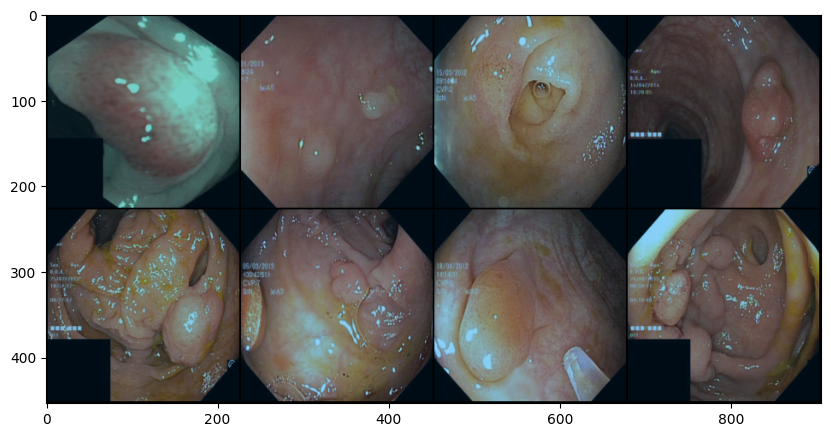

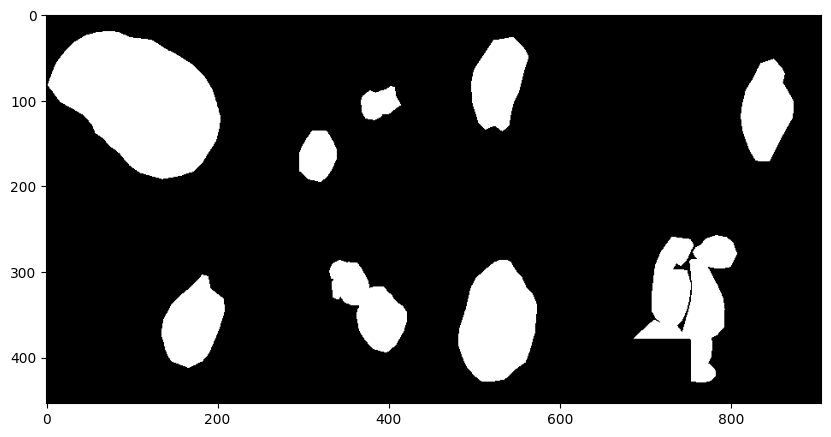

In [25]:
# Display a batch of images and masks
show_batch(train_features, train_labels)

#### 3. Define Model

Check device.

In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Import some required libraries.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models
import torch.optim as optim


Define the ConvRelu.

In [28]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out) 
        # self.batchnorm = nn.BatchNorm2d(out)
        self.relu = nn.ReLU(inplace=True) 
    def forward(self, x):
        x = self.conv(x) 
        # x = self.batchnorm(x) 
        x = self.relu(x) 
        return x

In [29]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        # TODO: Nếu is_deconv là True, sử dụng ConvTranspose2d để tăng kích thước
        if is_deconv:
            self.block = nn.Sequential(
                # TODO: Thêm một lớp ConvRelu với in_channels và middle_channels
                ConvRelu(in_channels, middle_channels),

                # TODO: Thêm một lớp ConvTranspose2d với middle_channels và out_channels
                nn.ConvTranspose2d(in_channels=middle_channels, out_channels=out_channels, kernel_size=2, stride=2),

                # TODO: Thêm một lớp ReLU activation với inplace=True
                nn.ReLU(inplace=True)
            )
        # TODO: Nếu is_deconv là False, sử dụng Upsample để tăng kích thước
        else:
            self.block = nn.Sequential(
                # TODO: Thêm một lớp Upsample với scale_factor=2 và mode='bilinear'
                nn.Upsample(scale_factor=2, mode='bilinear'),

                # TODO: Thêm một lớp ConvRelu với in_channels và middle_channels
                ConvRelu(in_channels, middle_channels),

                # TODO: Thêm một lớp ConvRelu với middle_channels và out_channels
                ConvRelu(middle_channels, out_channels)
            )

    def forward(self, x):
        return self.block(x)

Define UNet11 model.

In [30]:
class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes: số lượng lớp đầu ra
        :param num_filters: số lượng bộ lọc sử dụng trong mạng
        :param pretrained: sử dụng mô hình VGG11 có trọng số pre-trained hay không
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # TODO: Lưu lại số lượng lớp đầu ra
        self.num_classes = num_classes

        # TODO: Kiểm tra nếu pretrained=True, sử dụng mô hình VGG11 với trọng số có sẵn
        if pretrained:
            self.encoder = models.vgg11(weights=models.vgg.VGG11_Weights.DEFAULT).features
        else:
            self.encoder = models.vgg11().features

        # TODO: Khởi tạo hàm kích hoạt ReLU
        self.relu = nn.ReLU(inplace=True)

        # TODO: Xây dựng các khối convolutional từ các lớp trong VGG11
        self.conv1 = nn.Sequential( # 3 to 64 channels
            self.encoder[0],
            # TODO: Thêm hàm kích hoạt ReLU
            self.relu
        )   

        self.conv2 = nn.Sequential( # 64 to 128 channels
            self.encoder[3],
            # TODO: Thêm hàm kích hoạt ReLU
            self.relu
        )

        # TODO: Tiếp tục xây dựng các khối convolutional cho conv3, conv4, conv5
        self.conv3 = nn.Sequential( # 128 to 256 channels
            self.encoder[6],
            # TODO: Thêm hàm kích hoạt ReLU
            self.relu,

            self.encoder[8],
            # TODO: Thêm hàm kích hoạt ReLU
            self.relu
        )

        self.conv4 = nn.Sequential( # 256 to 512 channels
            self.encoder[11],
            self.relu,

            self.encoder[13],
            self.relu   
        )

        self.conv5 = nn.Sequential( # 512 to 512 channels
            self.encoder[16],
            self.relu,

            self.encoder[18],
            self.relu
        )


        # TODO: Xây dựng khối center và decoder tương ứng
        self.center = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv) # 256 + 256 -> 256*2 -> 256 channels

        # TODO: Xây dựng các lớp decoder dec5, dec4, dec3, dec2, dec1 theo kiến trúc U-Net
        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 4)
        self.dec2 = DecoderBlock(128 + num_filters * 4, num_filters * 2 * 2, num_filters * 2)
        self.dec1 = DecoderBlock(64 + num_filters * 2, num_filters * 2, num_filters)
        # TODO: Xây dựng lớp final convolution
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        # TODO: Thực hiện forward pass theo thứ tự các tầng conv1 -> conv5, pool giữa các tầng
        conv1 = self.conv1(x) # 64, 224x224
        conv2 = self.conv2(self.pool(conv1)) # 128, 112x112
        # TODO: Tiếp tục cho đến conv5
        conv3 = self.conv3(self.pool(conv2)) # 256, 56x56
        conv4 = self.conv4(self.pool(conv3)) # 512, 28x28
        conv5 = self.conv5(self.pool(conv4)) # 512, 14x14

        # TODO: Truyền qua tầng center
        center = self.center(self.pool(conv5)) # 256, 7x7 -> 14x14

        # TODO: Ghép nối (concat) các đặc trưng từ encoder với decoder theo từng tầng
        dec5 = self.dec5(torch.cat([center, conv5], 1)) # 28x28
        # TODO: Tiếp tục với dec4, dec3, dec2, dec1
        dec4 = self.dec4(torch.cat([dec5, conv4], dim=1)) # 56x56
        dec3 = self.dec3(torch.cat([dec4, conv3], dim=1)) # 112x112
        dec2 = self.dec2(torch.cat([dec3, conv2], dim=1)) # 244x244
        dec1 = self.dec1(torch.cat([dec2, conv1], dim=1)) # 448x448
        dec1 = self.pool(dec1) # 244x244

        # TODO: Kiểm tra nếu num_classes > 1, sử dụng log_softmax, ngược lại sử dụng conv đầu ra
        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [31]:
# Create the model
from torchsummary import summary

model = UNet11(pretrained=True)
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
             ReLU-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

Intersection over Union (IoU) = $\frac{predit \cap target}{predit \cup target}$

In [32]:
def iou_pytorch(outputs, labels):
    outputs = outputs.squeeze().byte() 
    labels = labels.squeeze().byte()

    SMOOTH = 1e-8

    intersection = (outputs & labels).sum(dim = (1, 2))

    union = (outputs | labels).sum(dim = (1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou

Loss function: $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is our target and $\hat y$ is an output of the model, $\sigma$ is a logistic function.

In [33]:
import torch.nn as nn

nn.BCEWithLogitsLoss()


BCEWithLogitsLoss()

### 4. Train model

Define function to denormalize image.

In [34]:
def de_normalize(img, mean=mean, std=std):
    result = img * std + mean
    result = np.clip(result, 0.0, 1.0)

    return result


Define function to display the result.

In [35]:
@torch.inference_mode()
def display_prediction(model, image, target):
    model.eval()
    img = image[None,...].to(device)
    output = model(img)
    pred = (torch.sigmoid(output.squeeze()) > 0.5).to(int)


    plt.figure(figsize=(10, 5))

    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Input Image")
    plt.imshow(de_normalize(image.numpy().transpose(1,2,0)))

    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("Prediction")
    plt.imshow(pred.cpu().squeeze(), cmap='gray')

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("Ground Truth")
    plt.imshow(target.numpy().transpose(1, 2, 0), cmap='gray')

    plt.show()


In [36]:
# Choose one set of image, mask in train set to display
idx = np.random.randint(0, len(train_dataset) - 1)
display_image = train_dataset[idx][0]
display_mask = train_dataset[idx][1]

Define evaluate model.

In [37]:
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_IOU = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            predict_labels = (torch.sigmoid(outputs.squeeze()) > 0.5).to(int)
            val_IOU += iou_pytorch(predict_labels, labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_IOU = val_IOU / total
    return val_loss, val_IOU


Define train function.

In [38]:
def train(model, train_loader, val_loader, criterion, optimizer, max_epoch=50, output_path='best_model.pt'):
    # save progress
    train_losses = []
    val_losses = []
    train_IOUs = []
    val_IOUs = []
    best_IOU = 0.0

    for epoch in range(max_epoch):
        model.train()

        running_loss = 0.0
        running_IOU = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device) 

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Calculate IOU
            total += labels.size(0)
            predict_labels = (torch.sigmoid(outputs.squeeze()) > 0.5).to(int)

            running_IOU += iou_pytorch(predict_labels, labels).sum().item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / len(train_loader)
        epoch_IOU = running_IOU / total
        val_loss, val_IOU = evaluate(model, val_loader, criterion)

        if val_IOU > best_IOU:
            best_IOU = val_IOU
            model_scripted = torch.jit.script(model) # Export to TorchScript
            model_scripted.save(output_path) # Save

        print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, IOU: {epoch_IOU:.2f}, Val Loss: {val_loss:.4f}, Val IOU: {val_IOU:.2f}")
        display_prediction(model, display_image, display_mask)


        # Save for plot
        train_losses.append(epoch_loss)
        train_IOUs.append(epoch_IOU)
        val_losses.append(val_loss)
        val_IOUs.append(val_IOU)

    return [train_losses, val_losses, train_IOUs, val_IOUs]


Epoch [1/20], Loss: 0.5220, IOU: 0.04, Val Loss: 0.3404, Val IOU: 0.00


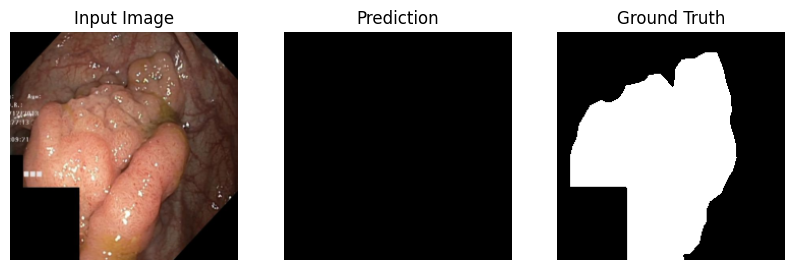

Epoch [2/20], Loss: 0.2978, IOU: 0.00, Val Loss: 0.2414, Val IOU: 0.00


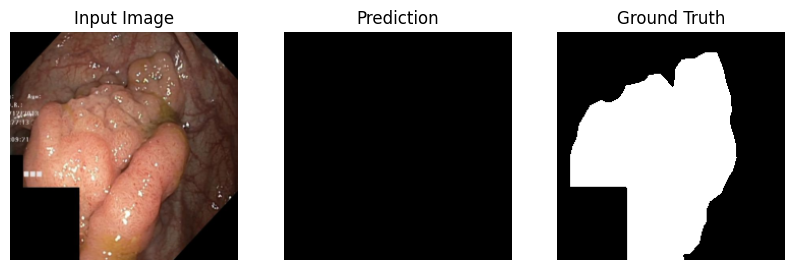

Epoch [3/20], Loss: 0.2340, IOU: 0.23, Val Loss: 0.2219, Val IOU: 0.40


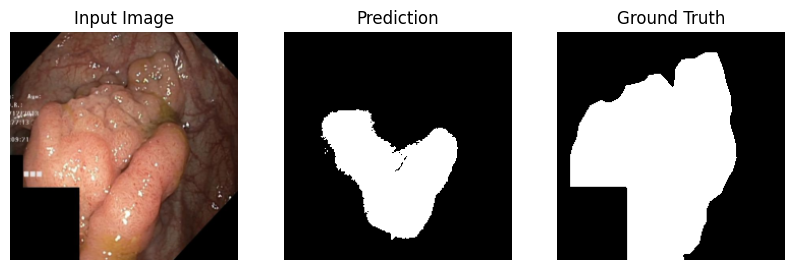

Epoch [4/20], Loss: 0.2052, IOU: 0.54, Val Loss: 0.1552, Val IOU: 0.61


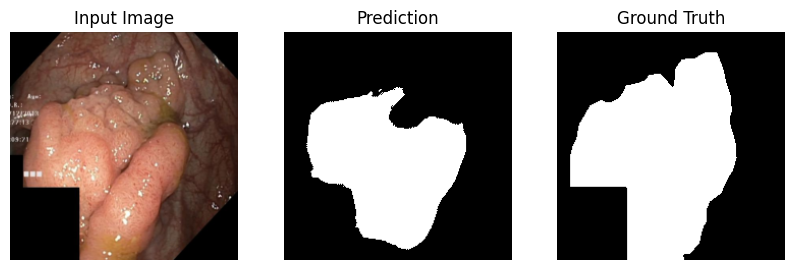

Epoch [5/20], Loss: 0.1569, IOU: 0.62, Val Loss: 0.1276, Val IOU: 0.67


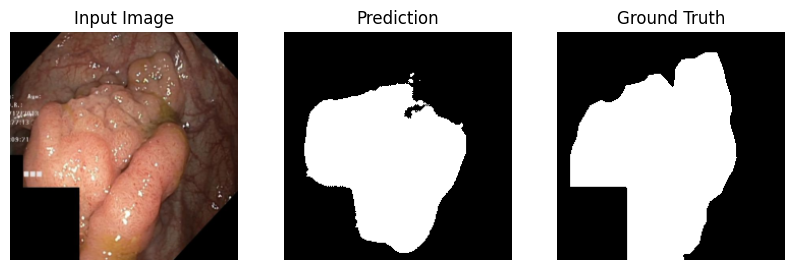

Epoch [6/20], Loss: 0.1294, IOU: 0.67, Val Loss: 0.1002, Val IOU: 0.70


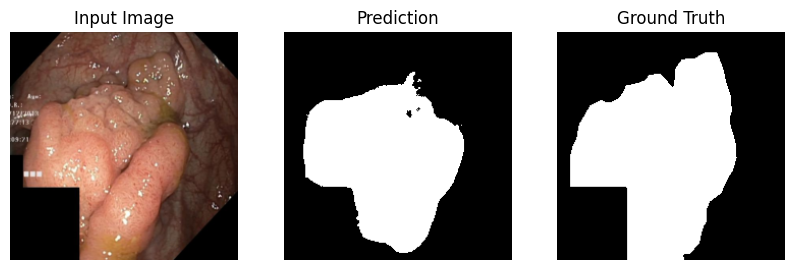

Epoch [7/20], Loss: 0.1055, IOU: 0.71, Val Loss: 0.1362, Val IOU: 0.58


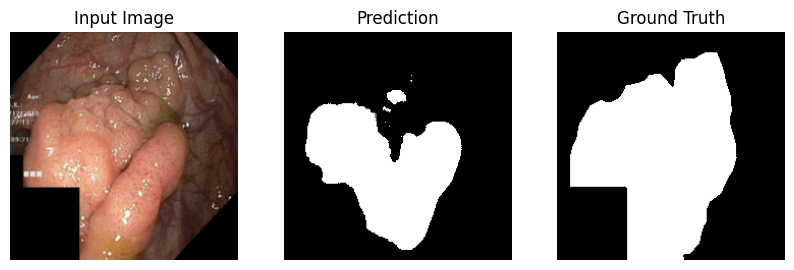

Epoch [8/20], Loss: 0.1032, IOU: 0.72, Val Loss: 0.1049, Val IOU: 0.68


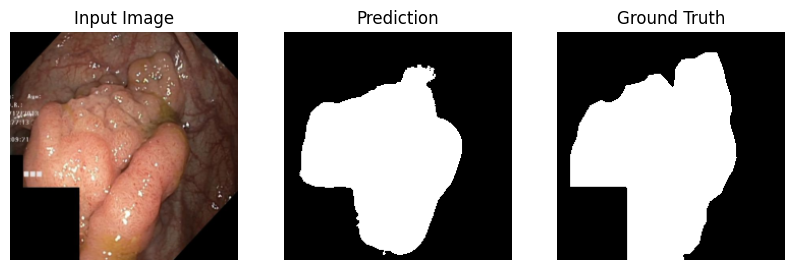

Epoch [9/20], Loss: 0.0934, IOU: 0.74, Val Loss: 0.0940, Val IOU: 0.71


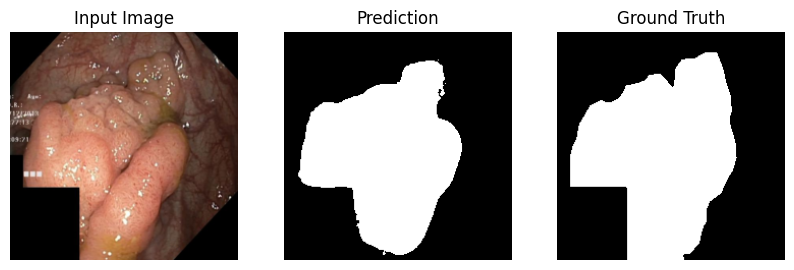

Epoch [10/20], Loss: 0.1016, IOU: 0.73, Val Loss: 0.0724, Val IOU: 0.79


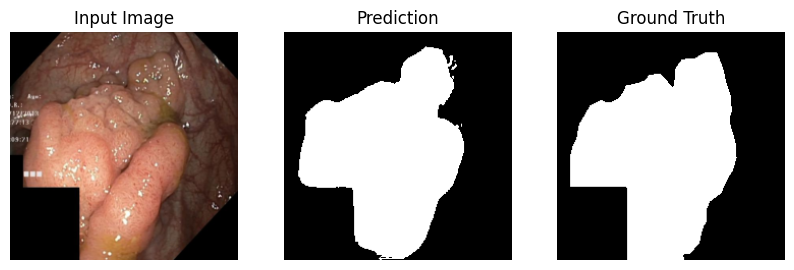

Epoch [11/20], Loss: 0.0707, IOU: 0.79, Val Loss: 0.0487, Val IOU: 0.83


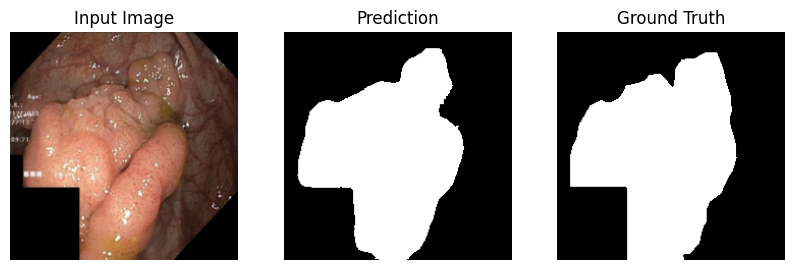

Epoch [12/20], Loss: 0.0458, IOU: 0.85, Val Loss: 0.0382, Val IOU: 0.86


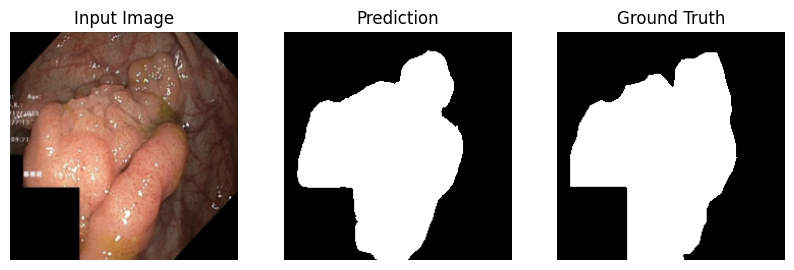

Epoch [13/20], Loss: 0.0370, IOU: 0.87, Val Loss: 0.0320, Val IOU: 0.88


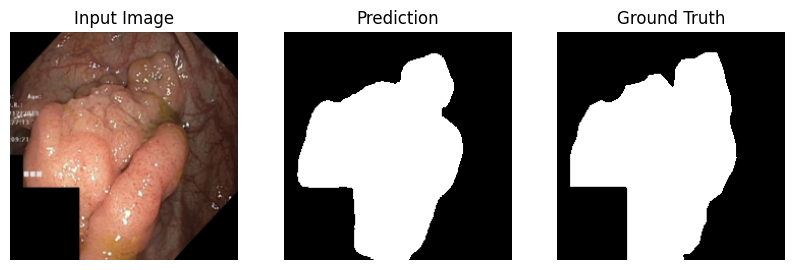

Epoch [14/20], Loss: 0.0310, IOU: 0.89, Val Loss: 0.0283, Val IOU: 0.89


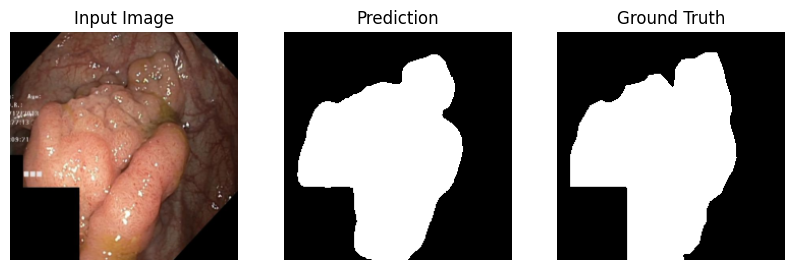

Epoch [15/20], Loss: 0.0284, IOU: 0.90, Val Loss: 0.0275, Val IOU: 0.89


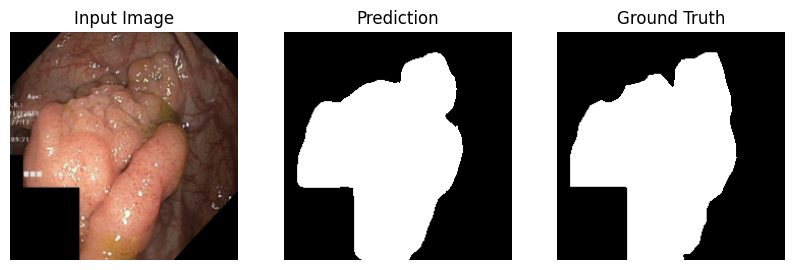

Epoch [16/20], Loss: 0.0339, IOU: 0.88, Val Loss: 0.0674, Val IOU: 0.78


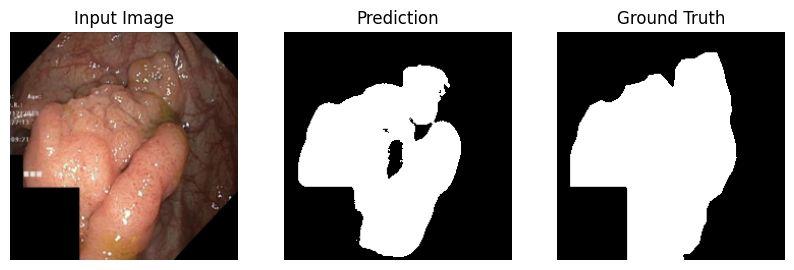

Epoch [17/20], Loss: 0.0412, IOU: 0.87, Val Loss: 0.0344, Val IOU: 0.88


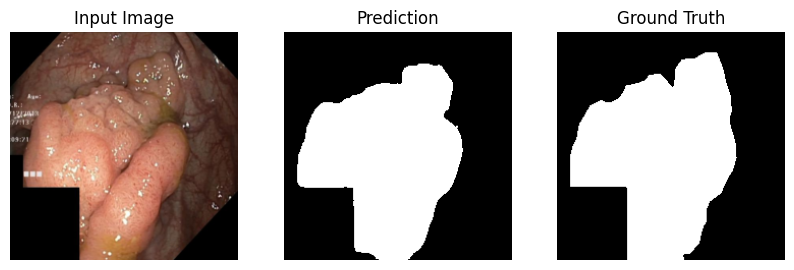

Epoch [18/20], Loss: 0.0349, IOU: 0.88, Val Loss: 0.0442, Val IOU: 0.86


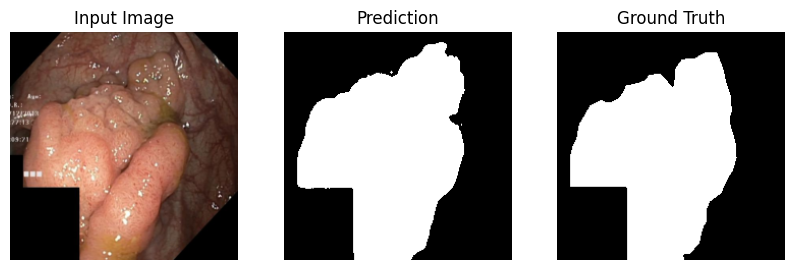

Epoch [19/20], Loss: 0.0383, IOU: 0.87, Val Loss: 0.0298, Val IOU: 0.90


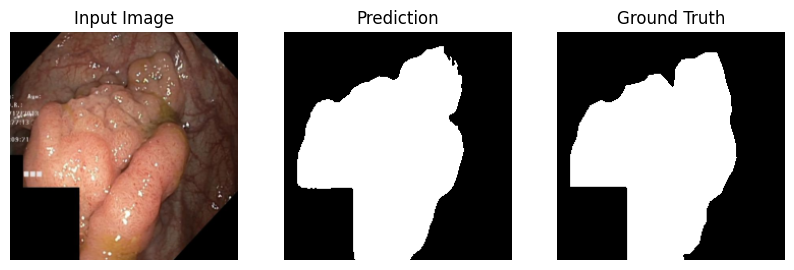

Epoch [20/20], Loss: 0.0335, IOU: 0.88, Val Loss: 0.0351, Val IOU: 0.88


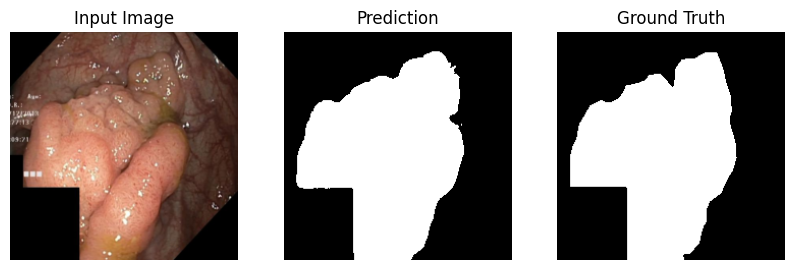

In [39]:
# Train the model
max_epoch = 20
lr = 4e-5
weight_decay = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
history_bce = train(model, train_loader, val_loader, criterion, optimizer, max_epoch, 'best_unet11_model.pt')

### 5. Plot chart

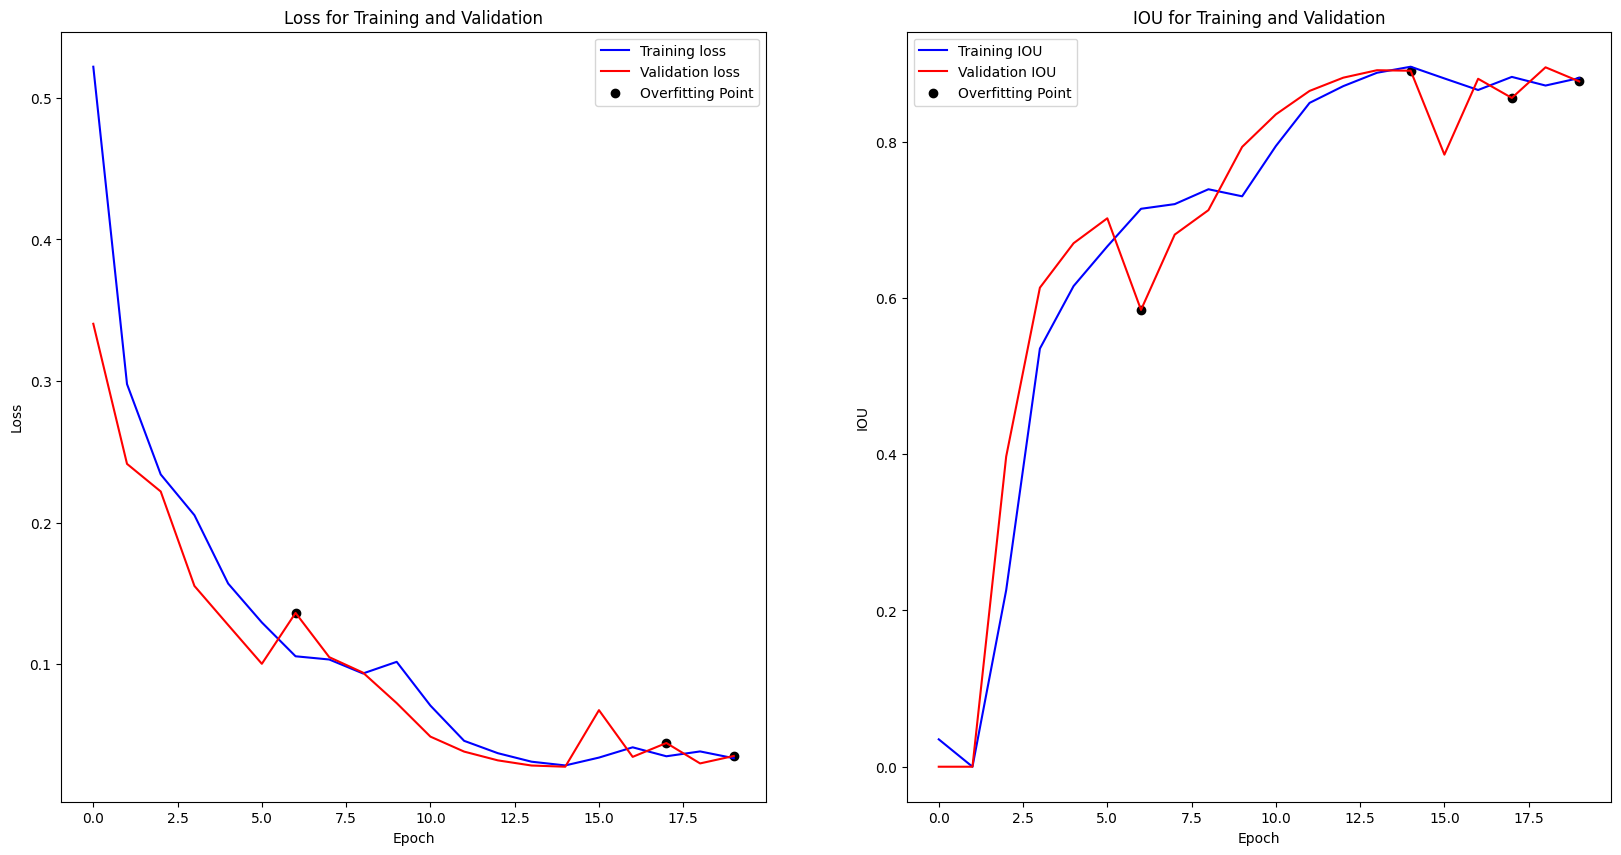

In [40]:
[train_losses, val_losses, train_IOUs, val_IOUs] = history_bce

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Xác định các epoch có xu hướng overfitting
epochs = np.arange(len(train_losses))

# Điều kiện: Train loss giảm nhưng Val loss tăng
overfit_loss_epochs = [i for i in range(1, len(train_losses)) 
                       if train_losses[i] < train_losses[i-1] and val_losses[i] > val_losses[i-1]]

# Điều kiện: Train IOU tăng nhưng Val IOU giảm
overfit_iou_epochs = [i for i in range(1, len(train_IOUs)) 
                      if train_IOUs[i] > train_IOUs[i-1] and val_IOUs[i] < val_IOUs[i-1]]

# Vẽ loss
axes[0].plot(train_losses, label='Training loss', color='blue')
axes[0].plot(val_losses, label='Validation loss', color='red')
axes[0].scatter(overfit_loss_epochs, [val_losses[i] for i in overfit_loss_epochs], 
                color='black', marker='o', label='Overfitting Point')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss for Training and Validation')
axes[0].legend()

# Vẽ IOU
axes[1].plot(train_IOUs, label='Training IOU', color='blue')
axes[1].plot(val_IOUs, label='Validation IOU', color='red')
axes[1].scatter(overfit_iou_epochs, [val_IOUs[i] for i in overfit_iou_epochs], 
                color='black', marker='o', label='Overfitting Point')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IOU')
axes[1].set_title('IOU for Training and Validation')
axes[1].legend()

plt.show()